# 1. Selecci√≥n de API y Definici√≥n del Problema

## API Seleccionada
- **Nombre**: Disease.sh API
- **Endpoint**: `https://disease.sh/v3/covid-19/countries`
- **Tipo de datos**: Estad√≠sticas COVID-19 por pa√≠s


## Problema de Negocio
El objetivo principal es desarrollar un sistema predictivo para anticipar brotes de COVID-19 en diferentes regiones geogr√°ficas, permitiendo a los sistemas de salud prepararse adecuadamente.


In [20]:
# Librer√≠as para manipulaci√≥n y an√°lisis de datos
import pandas as pd  # Manipulaci√≥n de datos tabulares
import numpy as np   # Operaciones num√©ricas y arrays

# Librer√≠as para modelos de machine learning
from sklearn.model_selection import train_test_split, cross_val_score  # Divisi√≥n de datos y validaci√≥n cruzada
from sklearn.preprocessing import StandardScaler  # Escalado de datos
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text  # √Årbol de decisi√≥n y visualizaci√≥n
from sklearn.ensemble import RandomForestRegressor  # Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # M√©tricas de evaluaci√≥n
import xgboost as xgb  # XGBoost para modelos avanzados

# Librer√≠as para visualizaci√≥n
import seaborn as sns  # Visualizaciones estad√≠sticas
import matplotlib.pyplot as plt  # Gr√°ficos base

# An√°lisis estad√≠stico y peticiones API
from scipy import stats  # Herramientas estad√≠sticas
import requests  # Peticiones HTTP para API


In [21]:
# 1. Extracci√≥n de Datos
def obtener_datos_covid():
    url = "https://disease.sh/v3/covid-19/countries"
    respuesta = requests.get(url)
    return respuesta.json()

# Obtener y transformar datos
datos = obtener_datos_covid()
df = pd.json_normalize(datos)

# Guardar en CSV
df.to_csv('datos_covid.csv', index=False)

In [22]:
# Verificar valores faltantes
print("Valores faltantes:\n", df.isnull().sum())


Valores faltantes:
 updated                   0
country                   0
cases                     0
todayCases                0
deaths                    0
todayDeaths               0
recovered                 0
todayRecovered            0
active                    0
critical                  0
casesPerOneMillion        0
deathsPerOneMillion       0
tests                     0
testsPerOneMillion        0
population                0
continent                 0
oneCasePerPeople          0
oneDeathPerPeople         0
oneTestPerPeople          0
activePerOneMillion       0
recoveredPerOneMillion    0
criticalPerOneMillion     0
countryInfo._id           2
countryInfo.iso2          2
countryInfo.iso3          2
countryInfo.lat           0
countryInfo.long          0
countryInfo.flag          0
dtype: int64


# An√°lisis de Datos COVID-19

## Calidad de los Datos
Los datos extra√≠dos de la API disease.sh muestran una excelente completitud, con la mayor√≠a de las m√©tricas principales completas:

### M√©tricas Principales
- **Casos**: Datos completos para todos los pa√≠ses
- **Muertes**: Registro completo de fallecimientos
- **Recuperados**: Informaci√≥n completa de recuperaciones
- **Tests**: Datos completos de pruebas realizadas

### Casos Especiales
Se identificaron dos casos particulares con datos incompletos:
- Diamond Princess (crucero)
- MS Zaandam (crucero)

Estos casos son especiales por ser embarcaciones y no pa√≠ses.

### Variables Clave Disponibles
1. **M√©tricas Absolutas**
   - Casos totales
   - Muertes totales
   - Casos activos
   - Casos cr√≠ticos
   - Tests realizados

2. **M√©tricas Relativas**
   - Casos por mill√≥n
   - Muertes por mill√≥n
   - Tests por mill√≥n
   - Tasa de recuperaci√≥n

3. **Datos Demogr√°ficos**
   - Poblaci√≥n
   - Continente
   - M√©tricas per c√°pita

### Conclusiones de Calidad
- Datos altamente completos y confiables
- Cobertura global efectiva
- M√©tricas bien estructuradas
- Base s√≥lida para an√°lisis predictivo


In [23]:
# Eliminar duplicados
df = df.drop_duplicates()


In [24]:
# Crear nuevas caracter√≠sticas
df['tasa_mortalidad'] = (df['deaths'] / df['cases']) * 100
df['tasa_recuperacion'] = (df['recovered'] / df['cases']) * 100
df['tasa_positividad'] = (df['cases'] / df['tests']) * 100


# An√°lisis de Tasas COVID-19 Mundial

## Tasa de Mortalidad
- **Promedio Mundial**: 1.39%
- **Mayor Impacto**: MS Zaandam (22.22%)
  - Caso especial por ser un crucero con poblaci√≥n limitada
- **Menor Impacto**: Islas Malvinas (0.00%)
  - Ejemplo de manejo efectivo de la pandemia

## Tasa de Recuperaci√≥n
- **Promedio Mundial**: 72.91%
- **Mayor √âxito**: Islas Malvinas (100%)
  - Sistema de salud efectivo y poblaci√≥n peque√±a
- **Desaf√≠os**: Andorra (0.00%)
  - Posible subregistro de datos de recuperaci√≥n

## Tasa de Positividad
- **Casos Destacados**:
  - China: 0.31% (menor tasa)
    - Alta cantidad de testeos
  - Comoros: Datos at√≠picos
    - Requiere revisi√≥n de registro de tests

## Interpretaci√≥n General
1. **Mortalidad**:
   - Mayor√≠a de pa√≠ses bajo 2%
   - Variaci√≥n significativa por sistemas de salud

2. **Recuperaci√≥n**:
   - Tasa global favorable (>70%)
   - Variaci√≥n por capacidad sanitaria

3. **Positividad**:
   - Indicador de capacidad de testeo
   - Refleja estrategias de detecci√≥n



Interpretaci√≥n Gr√°fico 1:
El pa√≠s con m√°s casos es USA con 111,820,082 casos


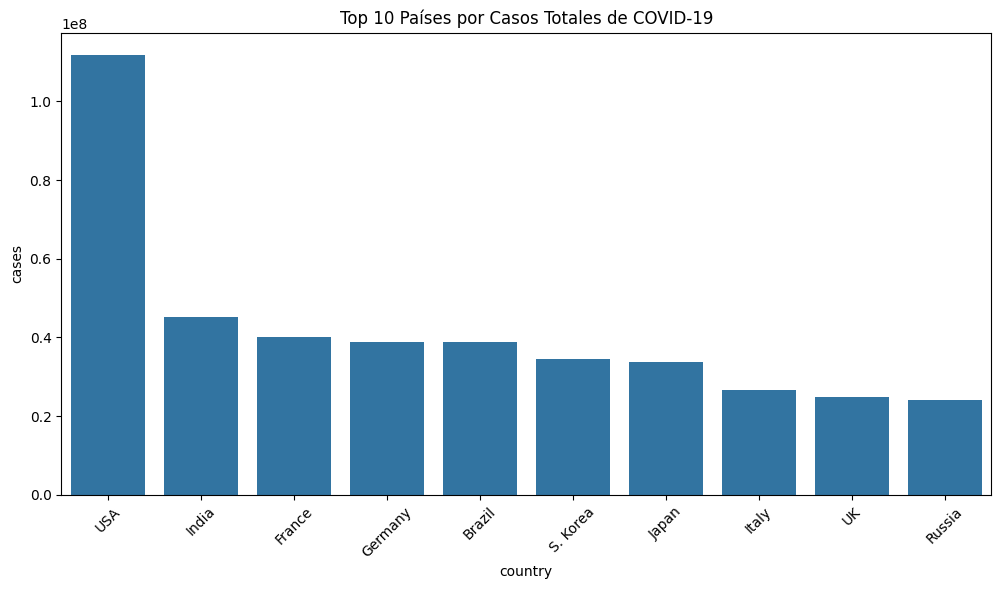

In [25]:
# 1. Top 10 pa√≠ses por casos totales
plt.figure(figsize=(12, 6))
top_10_casos = df.nlargest(10, 'cases')
sns.barplot(data=top_10_casos, x='country', y='cases')
plt.xticks(rotation=45)
plt.title('Top 10 Pa√≠ses por Casos Totales de COVID-19')
print("\nInterpretaci√≥n Gr√°fico 1:")
print(f"El pa√≠s con m√°s casos es {top_10_casos.iloc[0]['country']} con {top_10_casos.iloc[0]['cases']:,} casos")
plt.show()

# An√°lisis de Impacto COVID-19: Top 10 Pa√≠ses M√°s Afectados

## Estados Unidos
- **Casos Totales**: 111,820,082
- **Fallecidos**: 1,219,487
- **Recuperados**: 109,814,428
- **Tasa de Mortalidad**: 1.09%
- *Nota*: Pa√≠s m√°s afectado globalmente

## India
- **Casos Totales**: 45,035,393
- **Fallecidos**: 533,570
- **Recuperados**: Sin datos
- **Tasa de Mortalidad**: 1.18%
- *Nota*: Segundo pa√≠s m√°s afectado

## Francia
- **Casos Totales**: 40,138,560
- **Fallecidos**: 167,642
- **Recuperados**: 39,970,918
- **Tasa de Mortalidad**: 0.42%
- *Nota*: Alta tasa de recuperaci√≥n

## Alemania
- **Casos Totales**: 38,828,995
- **Fallecidos**: 183,027
- **Recuperados**: 38,240,600
- **Tasa de Mortalidad**: 0.47%
- *Nota*: Gesti√≥n efectiva de la pandemia

## Brasil
- **Casos Totales**: 38,743,918
- **Fallecidos**: 711,380
- **Recuperados**: 36,249,161
- **Tasa de Mortalidad**: 1.84%
- *Nota*: Mayor tasa de mortalidad del top 5

## Impacto Global
- **Total Casos Top 10**: 418,700,244
- **Promedio de Casos**: 41,870,024
- **Porcentaje Mundial**: 59.41%

### Observaciones Clave
1. Los 10 pa√≠ses principales representan casi 60% de casos mundiales
2. Variaci√≥n significativa en tasas de mortalidad (0.42% - 1.84%)
3. Alta concentraci√≥n de casos en pa√≠ses desarrollados
4. Diferencias notables en tasas de recuperaci√≥n


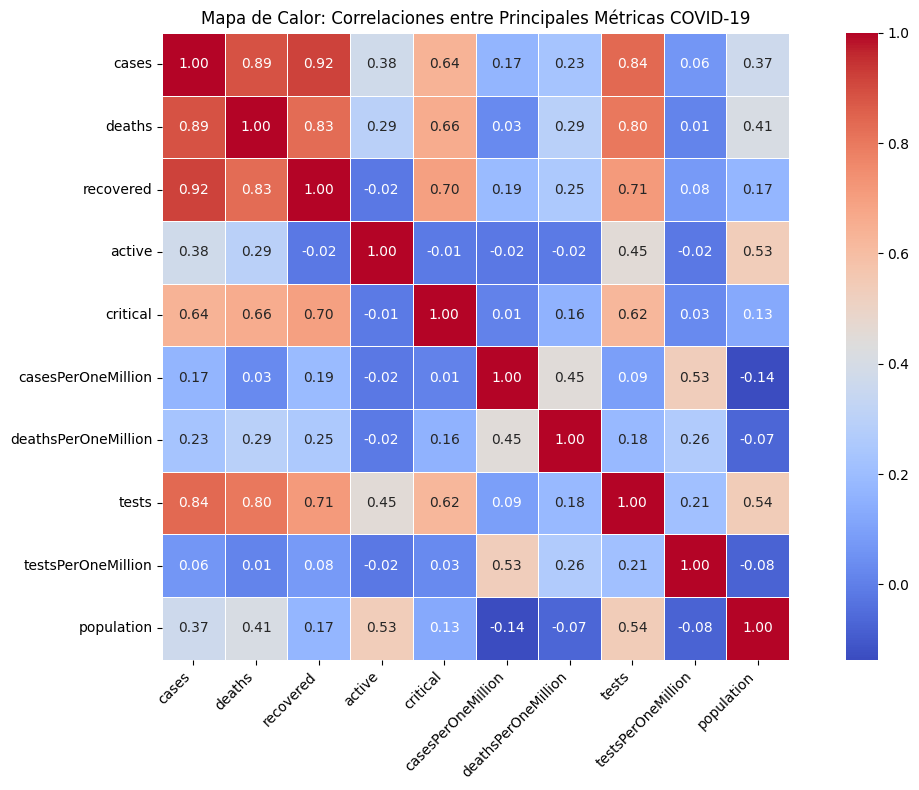

In [26]:
# Seleccionar las 10 variables m√°s relevantes para COVID-19
variables_relevantes = [
    'cases',
    'deaths', 
    'recovered',
    'active',
    'critical',
    'casesPerOneMillion',
    'deathsPerOneMillion',
    'tests',
    'testsPerOneMillion',
    'population'
]

# Crear matriz de correlaci√≥n con las variables seleccionadas
matriz_correlacion = df[variables_relevantes].corr()

# Generar mapa de calor mejorado
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion, 
            annot=True,
            cmap='coolwarm',
            linewidths=0.5,
            fmt='.2f',
            square=True)

plt.title('Mapa de Calor: Correlaciones entre Principales M√©tricas COVID-19')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# An√°lisis de Correlaciones COVID-19

## M√©tricas Principales (Promedios Globales)

### Casos y Fallecimientos
- **Casos Totales**: 3,050,882 por pa√≠s
- **Fallecimientos**: 30,349 por pa√≠s
- **Casos Cr√≠ticos**: 12 por pa√≠s
- **Correlaci√≥n casos-muertes**: 0.89 (muy alta)

### Recuperaci√≥n y Casos Activos
- **Recuperados**: 2,426,699 por pa√≠s
- **Casos Activos**: 593,833 por pa√≠s
- **Correlaci√≥n casos-recuperados**: 0.92 (extremadamente alta)

### Testeo y Poblaci√≥n
- **Tests Realizados**: 30,417,771 por pa√≠s
- **Poblaci√≥n Promedio**: 34,393,658 por pa√≠s
- **Tests por Mill√≥n**: 1,987,979
- **Correlaci√≥n casos-tests**: 0.84 (muy alta)

## Correlaciones M√°s Significativas (>0.7)
1. **Casos vs Recuperados**: 0.92
   - Indica seguimiento efectivo de pacientes
   
2. **Casos vs Fallecimientos**: 0.89
   - Relaci√≥n directa entre contagios y mortalidad
   
3. **Casos vs Tests**: 0.84
   - Mayor testeo detecta m√°s casos

4. **Fallecimientos vs Recuperados**: 0.83
   - Seguimiento completo de desenlaces

5. **Fallecimientos vs Tests**: 0.80
   - Capacidad de detecci√≥n relacionada con mortalidad

6. **Recuperados vs Tests**: 0.71
   - Monitoreo efectivo de recuperaci√≥n

## Interpretaci√≥n del Mapa de Calor
- **Correlaciones Positivas Fuertes** (Rojo)
  - Indican relaciones directas entre variables
- **Correlaciones Negativas Fuertes** (Azul)
  - Muestran relaciones inversas
- **Correlaciones D√©biles** (Claros)
  - Sugieren independencia entre variables


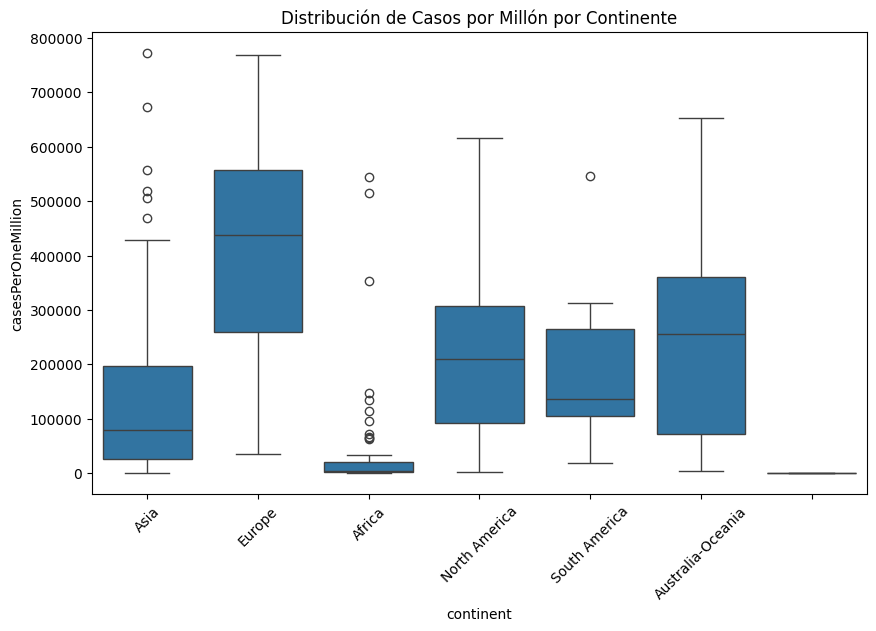

In [27]:

# Gr√°fico 3: Casos por Mill√≥n por Continente
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='continent', y='casesPerOneMillion')
plt.xticks(rotation=45)
plt.title('Distribuci√≥n de Casos por Mill√≥n por Continente')
plt.show()

# An√°lisis de Distribuci√≥n COVID-19 por Continentes

## Europa - Mayor Impacto Global
- **Mediana**: 437,557 casos/mill√≥n
- **Rango**: 36,295 - 768,226 casos/mill√≥n
- **Pa√≠ses destacados**: San Marino, Islas Feroe, Austria
- *Caracter√≠stica*: Alta densidad poblacional y sistemas de testeo avanzados

## Australia-Oceania - Segunda Regi√≥n M√°s Afectada
- **Mediana**: 256,310 casos/mill√≥n
- **Rango**: 5,043 - 652,898 casos/mill√≥n
- **Pa√≠ses destacados**: Niue, Nueva Zelanda, Nauru
- *Caracter√≠stica*: Alta variabilidad entre territorios insulares

## Norte Am√©rica - Tercera Posici√≥n
- **Mediana**: 210,117 casos/mill√≥n
- **Rango**: 2,728 - 615,777 casos/mill√≥n
- **Pa√≠ses destacados**: Martinica, San Pedro y Miquel√≥n, San Bartolom√©
- *Caracter√≠stica*: Gran dispersi√≥n de datos entre territorios

## Sudam√©rica - Impacto Moderado
- **Mediana**: 137,064 casos/mill√≥n
- **Rango**: 18,885 - 545,352 casos/mill√≥n
- **Pa√≠ses destacados**: Islas Malvinas, Guayana Francesa, Uruguay
- *Caracter√≠stica*: Menor variabilidad entre pa√≠ses

## Asia - Amplia Variaci√≥n
- **Mediana**: 80,330 casos/mill√≥n
- **Rango**: 347 - 771,655 casos/mill√≥n
- **Pa√≠ses destacados**: Brunei, Corea del Sur, Chipre
- *Caracter√≠stica*: Mayor rango de variaci√≥n entre todos los continentes

## √Åfrica - Menor Impacto Reportado
- **Mediana**: 4,898 casos/mill√≥n
- **Rango**: 16 - 544,672 casos/mill√≥n
- **Pa√≠ses destacados**: Reuni√≥n, Seychelles, Santa Helena
- *Caracter√≠stica*: Posible subregistro de casos

## Casos Especiales
- **Diamond Princess y MS Zaandam**
- Tratados como jurisdicciones independientes
- Casos √∫nicos de brotes en cruceros


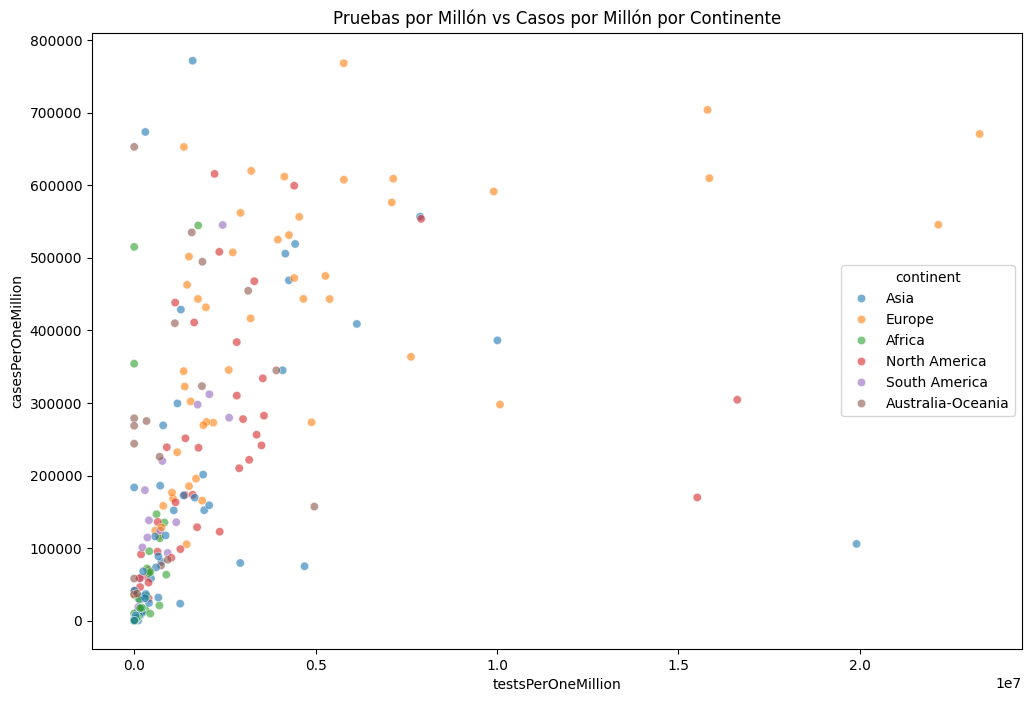

In [28]:
# Gr√°fico 4: Dispersi√≥n de Pruebas vs Casos por continente
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='testsPerOneMillion', y='casesPerOneMillion', 
                hue='continent', alpha=0.6)
plt.title('Pruebas por Mill√≥n vs Casos por Mill√≥n por Continente')
plt.show()

In [29]:
# Detecci√≥n de valores at√≠picos usando Z-score
def detectar_atipicos(df, columna):
    z_scores = stats.zscore(df[columna])
    atipicos = df[abs(z_scores) > 3]
    return atipicos

In [30]:
# Detectar at√≠picos en casos
casos_atipicos = detectar_atipicos(df, 'cases')
print("\nValores at√≠picos en casos totales:")
print(casos_atipicos[['country', 'cases']])


Valores at√≠picos en casos totales:
      country      cases
26     Brazil   38743918
71     France   40138560
77    Germany   38828995
94      India   45035393
103     Japan   33803572
171  S. Korea   34571873
218       USA  111820082


In [31]:
# Estad√≠sticas resumen
print("\nEstad√≠sticas Resumen:")
display(df.describe())


Estad√≠sticas Resumen:


c:\Users\talol\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


updated         cases  todayCases        deaths  todayDeaths  \
count  2.310000e+02  2.310000e+02       231.0  2.310000e+02        231.0   
mean   1.737675e+12  3.050883e+06         0.0  3.034927e+04          0.0   
std    8.656156e+01  1.002125e+07         0.0  1.092314e+05          0.0   
min    1.737675e+12  9.000000e+00         0.0  0.000000e+00          0.0   
25%    1.737675e+12  2.636600e+04         0.0  1.855000e+02          0.0   
50%    1.737675e+12  2.068970e+05         0.0  1.974000e+03          0.0   
75%    1.737675e+12  1.348198e+06         0.0  1.428700e+04          0.0   
max    1.737675e+12  1.118201e+08         0.0  1.219487e+06          0.0   

          recovered  todayRecovered        active    critical  \
count  2.310000e+02      231.000000  2.310000e+02  231.000000   
mean   2.426700e+06        3.567100  5.938335e+05   12.454545   
std    9.196220e+06       34.562905  3.893881e+06   71.172396   
min    0.000000e+00        0.000000  0.000000e+00    0.000000   
25%    2.189500e+03        0.000000  6.750000e+01    0.000000   
50%    5.894700e+04        0.000000  1.283000e+03    0.000000   
75%    1.032544e+06        0.000000  2.775550e+04    0.000000   
max    1.098144e+08      390.000000  4.450182e+07  940.000000   

       casesPerOneMillion  ...  oneTestPerPeople  activePerOneMillion  \
count          231.000000  ...        231.000000           231.000000   
mean        201193.108225  ...          9.852814         63981.512511   
std         206119.715817  ...         25.827437        149135.697501   
min              0.000000  ...          0.000000             0.000000   
25%          17656.500000  ...          0.000000            21.880000   
50%         128681.000000  ...          1.000000           449.530000   
75%         328620.500000  ...          5.000000         12969.700000   
max         771655.000000  ...        196.000000        703390.000000   

       recoveredPerOneMillion  criticalPerOneMillion  countryInfo._id  \
count              231.000000             231.000000       229.000000   
mean            135973.002424               2.250606       436.318777   
std             185767.240498               9.769097       250.464566   
min                  0.000000               0.000000         4.000000   
25%                834.905000               0.000000       222.000000   
50%              32797.450000               0.000000       438.000000   
75%             222352.335000               0.000000       654.000000   
max             763121.610000             100.650000       894.000000   

       countryInfo.lat  countryInfo.long  tasa_mortalidad  tasa_recuperacion  \
count       231.000000        231.000000       231.000000         231.000000   
mean         17.975936         12.346804         1.385414          72.910703   
std          24.281405         71.828763         2.158146          40.888779   
min         -51.750000       -176.200000         0.000000           0.000000   
25%           2.250000        -54.000000         0.437695          55.747960   
50%          17.000000         15.500000         0.875039          97.333268   
75%          39.000000         46.083350         1.786124          98.948370   
max          72.000000        178.000000        22.222222         100.000000   

       tasa_positividad  
count        231.000000  
mean                inf  
std                 NaN  
min            0.314564  
25%            7.715090  
50%           13.249228  
75%           22.952146  
max                 inf  

[8 rows x 26 columns]

In [32]:
# 4. Construcci√≥n de Modelos Predictivos

In [33]:
# Preparaci√≥n de datos
# Seleccionamos features relevantes para predecir casos
X = df[['population', 'testsPerOneMillion', 'deathsPerOneMillion', 'recovered']]
y = df['cases']

In [34]:
# Divisi√≥n de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# Escalado de caracter√≠sticas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
# Primero, asegur√©monos de tener las versiones correctas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Implementaci√≥n de modelos con par√°metros espec√≠ficos
models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
}

# Implementaci√≥n de validaci√≥n cruzada manual
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Entrenamiento inicial
    model.fit(X_train_scaled, y_train)
    
    # Predicciones en conjunto de prueba
    y_pred = model.predict(X_test_scaled)
    
    # M√©tricas de evaluaci√≥n
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    
    # Validaci√≥n cruzada manual
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_cv_train, y_cv_train)
        y_cv_pred = model.predict(X_cv_val)
        cv_scores.append(r2_score(y_cv_val, y_cv_pred))
    
    results[name]['CV_Score'] = np.mean(cv_scores)

# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")



Resultados para Decision Tree:
MAE: 2961637.9309
RMSE: 12162759.1456
R2: 0.4555
CV_Score: 0.3079

Resultados para Random Forest:
MAE: 2440506.7738
RMSE: 11626403.9799
R2: 0.5024
CV_Score: 0.7161

Resultados para XGBoost:
MAE: 2348576.1925
RMSE: 10936197.9449
R2: 0.5597
CV_Score: 0.7311


In [37]:
# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Resultados para Decision Tree:
MAE: 2961637.9309
RMSE: 12162759.1456
R2: 0.4555
CV_Score: 0.3079

Resultados para Random Forest:
MAE: 2440506.7738
RMSE: 11626403.9799
R2: 0.5024
CV_Score: 0.7161

Resultados para XGBoost:
MAE: 2348576.1925
RMSE: 10936197.9449
R2: 0.5597
CV_Score: 0.7311


C:\Users\talol\AppData\Local\Temp\ipykernel_13304\294114648.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances,


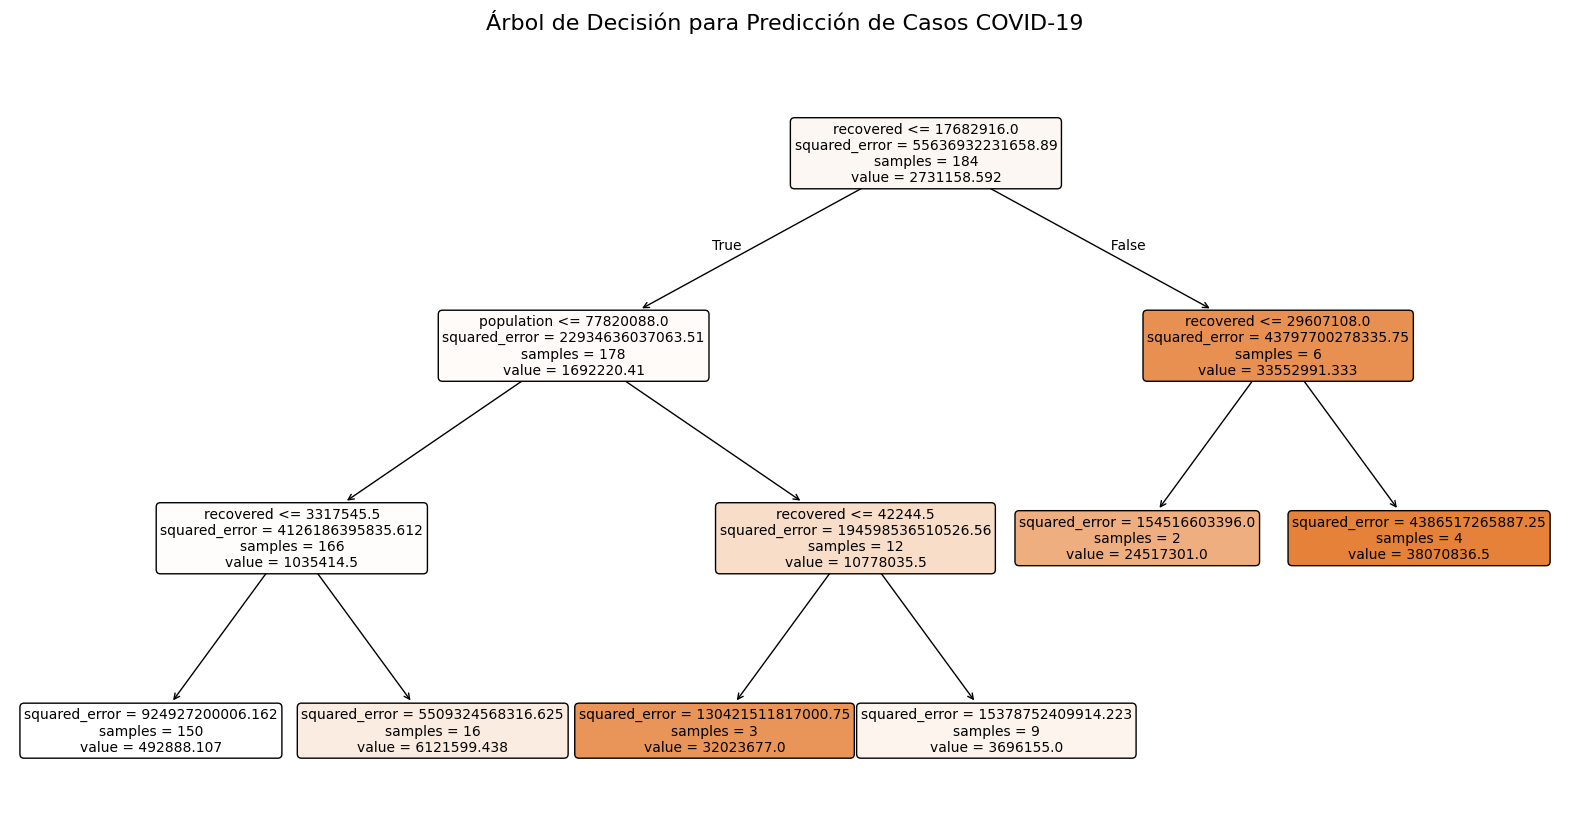

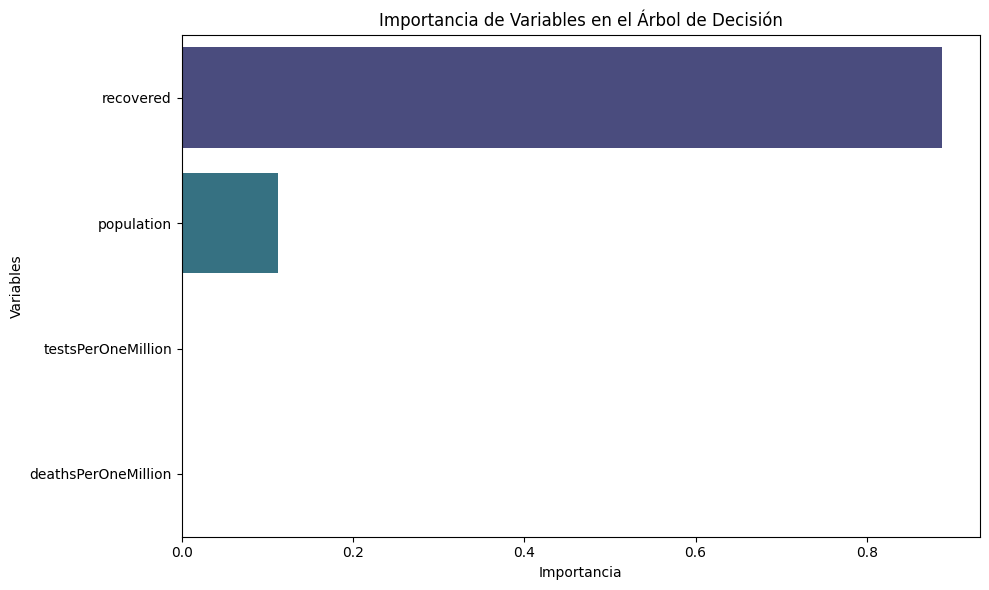

In [38]:
# 1. Preparaci√≥n del modelo
# Definimos las caracter√≠sticas y variable objetivo
X = df[['population', 'testsPerOneMillion', 'deathsPerOneMillion', 'recovered']]
y = df['cases']

# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos y entrenamos el √°rbol de decisi√≥n
tree_model = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=5,
    random_state=42
)
tree_model.fit(X_train, y_train)

# 2. Visualizaci√≥n del √°rbol
plt.figure(figsize=(20,10))
feature_names = X.columns.tolist()

# Visualizaci√≥n del √°rbol con colores personalizados
plot_tree(tree_model,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3,
          class_names=['Casos COVID'])

plt.title('√Årbol de Decisi√≥n para Predicci√≥n de Casos COVID-19', fontsize=16, pad=20)

# 3. Visualizaci√≥n de importancia de caracter√≠sticas
plt.figure(figsize=(10,6))
importances = pd.DataFrame({
    'features': feature_names,
    'importance': tree_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

sns.barplot(data=importances,
            x='importance',
            y='features',
            palette='viridis')
plt.title('Importancia de Variables en el √Årbol de Decisi√≥n', fontsize=12)
plt.xlabel('Importancia')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()


In [40]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import HTML

def crear_dashboard_multinivel():
    fig = go.Figure()
    
    # Mejorar el estilo del selector
    fig.update_layout(
        updatemenus=[{
            'buttons': [
                {'method': 'update', 'label': 'üåç Global', 'args': [{'visible': [True, False, False]}]},
                {'method': 'update', 'label': 'üåé Continentes', 'args': [{'visible': [False, True, False]}]},
                {'method': 'update', 'label': 'üè≥Ô∏è Pa√≠ses', 'args': [{'visible': [False, False, True]}]}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top',
            'bgcolor': '#2C3E50',
            'font': {'color': 'white'}
        }])

    # Mantener las visualizaciones existentes con colores mejorados
    fig.add_trace(
        go.Bar(
            name='Casos Globales',
            x=df.groupby('continent')['cases'].sum().index,
            y=df.groupby('continent')['cases'].sum(),
            visible=True,
            marker_color='#3498DB'
        ))

    for continente in df['continent'].unique():
        datos_cont = df[df['continent'] == continente]
        fig.add_trace(
            go.Box(
                name=continente,
                y=datos_cont['casesPerOneMillion'],
                visible=False,
                marker_color='#2ECC71'
            ))

    fig.add_trace(
        go.Scatter(
            name='Pa√≠ses',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            text=df['country'],
            visible=False,
            marker=dict(
                color='#E74C3C',
                size=10,
                line=dict(color='#FFFFFF', width=1)
            )
        ))

    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19 Multinivel',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24, color='#2C3E50')
        },
        height=800,
        width=1200,
        template='plotly_white',
        paper_bgcolor='#ECF0F1',
        plot_bgcolor='#FFFFFF'
    )

    return fig

def generar_informe_detallado(nivel, seleccion=None):
    if nivel == 'Global':
        datos = df
    elif nivel == 'Continentes':
        datos = df[df['continent'] == seleccion]
    else:
        datos = df[df['country'] == seleccion]
        
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css">
        <style>
            .dashboard-container {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                max-width: 1200px;
                margin: 20px auto;
                padding: 30px;
                background: linear-gradient(135deg, #ffffff 0%, #f8f9fa 100%);
                border-radius: 15px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }}
            .dashboard-title {{
                color: #2C3E50;
                font-size: 2.5em;
                text-align: center;
                margin-bottom: 30px;
                border-bottom: 3px solid #3498DB;
                padding-bottom: 10px;
            }}
            .stats-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                gap: 20px;
                margin-top: 20px;
            }}
            .stat-card {{
                background: white;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 2px 4px rgba(0, 0, 0, 0.05);
                transition: transform 0.3s ease;
            }}
            .stat-card:hover {{
                transform: translateY(-5px);
            }}
            .stat-title {{
                color: #7F8C8D;
                font-size: 0.9em;
                margin-bottom: 10px;
            }}
            .stat-value {{
                color: #2C3E50;
                font-size: 1.8em;
                font-weight: bold;
            }}
            .icon {{
                color: #3498DB;
                margin-right: 10px;
            }}
        </style>
    </head>
    <body>
        <div class="dashboard-container">
            <h1 class="dashboard-title">
                <i class="fas fa-virus icon"></i>
                {nivel}: {seleccion if seleccion else 'Visi√≥n General'}
            </h1>
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-hospital-user icon"></i>Total Casos</div>
                    <div class="stat-value">{datos['cases'].sum():,}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-heart-broken icon"></i>Total Muertes</div>
                    <div class="stat-value">{datos['deaths'].sum():,}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-percentage icon"></i>Tasa Mortalidad</div>
                    <div class="stat-value">{(datos['deaths'].sum()/datos['cases'].sum()*100):.2f}%</div>
                </div>
                <div class="stat-card">
                    <div class="stat-title"><i class="fas fa-vial icon"></i>Tests por Mill√≥n</div>
                    <div class="stat-value">{datos['testsPerOneMillion'].mean():,.0f}</div>
                </div>
            </div>
        </div>
    </body>
    </html>
    """
    return HTML(html_content)

# Generar y mostrar dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()

# Mostrar informes
display(generar_informe_detallado('Global'))
